In [74]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import csv
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
import os

,file105.txt,file106.txt,file107.txt,file112.txt,file115.txt,file120.txt,file16.txt,file17.txt,file2.txt,file20.txt,...,file67.txt,file68.txt,file72.txt,file77.txt,file81.txt,file85.txt,file9.txt,file92.txt,file97.txt,file99.txt
0,-25.533158,-41.328061,-1.136612,-21.316010,-31.422843,5.743710,-47.147684,-38.955163,54.228112,-15.192010,...,-34.969943,-33.615905,-36.068502,-24.238974,-20.562337,-41.050339,-40.621135,-10.998098,-22.291913,-31.010619
1,-25.480388,-41.405733,-1.103716,-21.263925,-31.390632,5.799907,-47.162516,-38.935696,54.299311,-15.143051,...,-35.005710,-33.569919,-35.981639,-24.198399,-20.480646,-41.208736,-40.493395,-11.022084,-22.249423,-31.136034
2,-25.431730,-41.341006,-1.063967,-21.177575,-31.325526,5.887628,-47.129145,-38.906031,54.351093,-15.101624,...,-35.072134,-33.692549,-35.956091,-24.134020,-20.403283,-41.254722,-40.442299,-10.844585,-22.204192,-30.943458
3,-25.366624,-41.166244,-1.020106,-21.112469,-31.289204,5.971923,-47.051279,-38.841139,54.273421,-15.056970,...,-34.913737,-33.626124,-35.884557,-24.054493,-20.329707,-41.229174,-40.549601,-10.756178,-22.143198,-31.080523
4,-25.333043,-41.140353,-0.967336,-21.044621,-31.229581,6.052792,-47.040156,-38.807765,54.279893,-15.003169,...,-34.785998,-33.631234,-35.802804,-23.985245,-20.211228,-41.673707,-40.457628,-10.643785,-22.087001,-30.912618


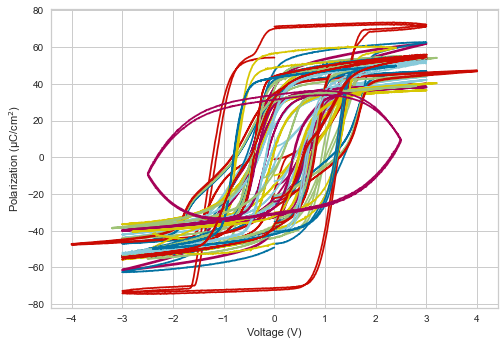

In [75]:
# Define directory to search for Radiant Hysteresis files. Ensure Data is within working directory
Dir = os.getcwd()+'\**\*.txt'
txt_files = glob.glob(Dir,recursive=True)

# Define Data Filters
m_type = 'Hysteresis' # the measurment type of interest
freq_period = 2 # period (ms) of Hysteresis measurment frequency (2 = 1kHz,0.4 = 5kHz, 0.2 = 10kHz)
max_voltage = 5
dfA = pd.DataFrame()
dfB = pd.DataFrame()

#Sample Variable Definition
def VarDefine(data,vname,col):
    for line in data:
        if vname in line and line[col]:
            return float(line[col])
        else:
            pass

#Voltage and Polarizaton Extraction
def Hys_spectrum(data,no_pts,s_thick,*args):
    for line in enumerate(data):
        if args[0] in line[1]:
            v_start=line[0]+1
            unit = 1
        elif args[1] in line[1]:
            v_start = line[0]+1
            unit = s_thick/10
        else:
            pass

    voltage = []
    polarization = []
    if v_start<60:
        for _ in range(0,int(no_pts)):
            voltage.append(float(data[v_start+_][2])*unit)
            polarization.append(float(data[v_start+_][3]))
    else:
        pass
    return voltage, polarization

#Scatter Plot 
def scatter_plot(voltage, polarization):
    plt.plot(voltage,polarization)
    plt.xlabel('Voltage (V)')
    plt.ylabel(u'Polarization (\u03bcC/cm$^2$)')
    plt.grid()

#Dataframe of only Queried Measurement types
def dframe(voltage,polarization,files,dfA,dfB):
    dfV = pd.DataFrame()
    dfP = pd.DataFrame()
    fname = files.split('\\')[-1]        
    dfV[fname] = voltage
    dfP[fname] = polarization
    dfA = pd.concat([dfA,dfP],axis=1)
    dfB = pd.concat([dfB,dfV],axis=1)
    return dfA,dfB

for files in txt_files:
    with open(files) as f:
        reader = csv.reader(f, delimiter="\t")
        data = list(reader)
    if m_type in data[0][0].split():  
        no_pts = VarDefine(data,'Points:',1)
        s_thick = VarDefine(data,'Sample Thickness (µm):',1)
        freq = VarDefine(data,'Hysteresis Period (ms):',1)
        voltage,polarization=Hys_spectrum(data,no_pts,s_thick,'Drive Voltage','Field (kV/cm)')

        #Plot Data and Set Figure Parameters
        if voltage and freq==freq_period and max(voltage)<max_voltage:
            fig = scatter_plot(voltage,polarization)
            dfA,dfB = dframe(voltage, polarization,files,dfA,dfB)
        else:
            pass
    else:
        pass

dfA.head()

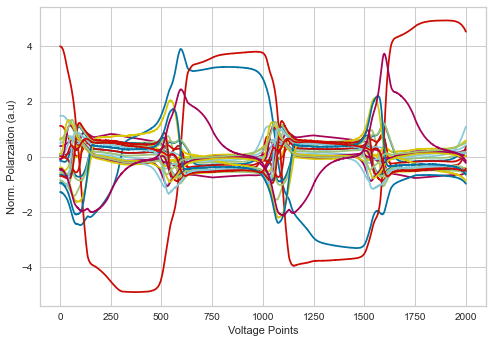

In [76]:
# Transform dataframe to have "features" on horizontal axis (i.e. columns)
data = dfA.T
# Scale features to unit scale
features = dfA.index

# Separating out the features
x = data.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Plot Normalized Polarzation
plt.plot(x.T)
plt.xlabel('Voltage Points')
plt.ylabel('Norm. Polarzaiton (a.u)')
plt.show()

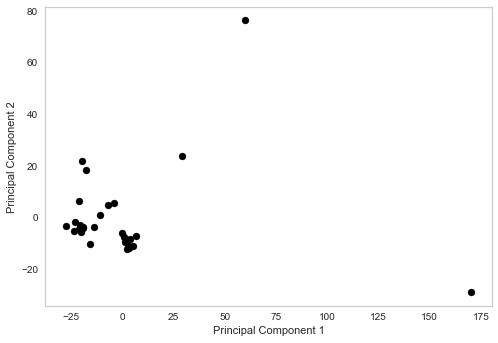

In [77]:
# Reduce data dimentionality with PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Plot data in principal component axes
plt.scatter(principalDf.loc[:, 'principal component 1'], principalDf.loc[:, 'principal component 2'], c = 'black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()

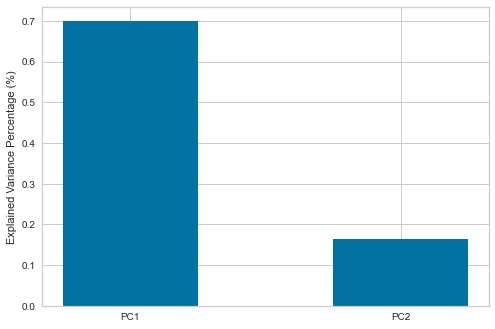

In [78]:
# Calculates percentage of variance captured by each principal component
plt.ylabel('Explained Variance Percentage (%)')
plt.bar(['PC1','PC2'], pca.explained_variance_ratio_, 0.5)
plt.show()

,principal component 1,principal component 2,ClusterID,FName
0,-19.033876,-3.876687,0,file105.txt
1,-22.917048,-1.756269,0,file106.txt
2,-13.878495,-3.534354,0,file107.txt
3,-27.686869,-3.143226,0,file112.txt
4,-20.918792,-3.006269,0,file115.txt


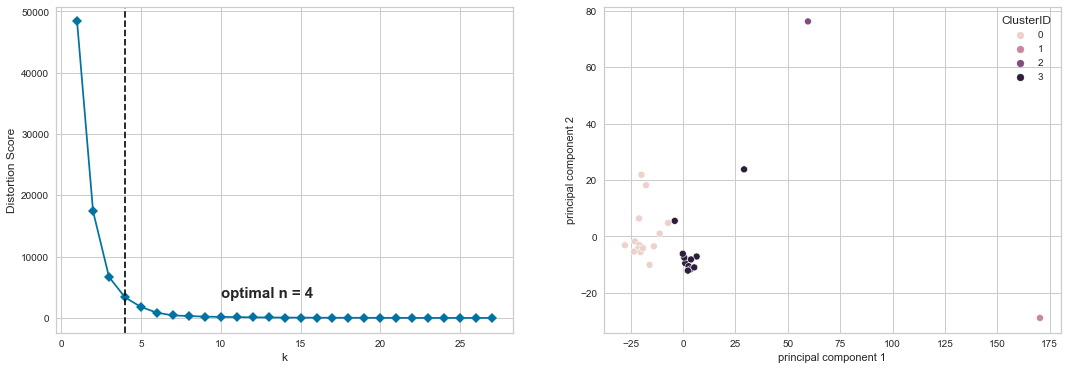

In [79]:
# K-means clustering of PCA data
fig, ax=plt.subplots(1,2)
fig.set_size_inches(18,6)

# Define optimal n_clusters via Elbow Method
ax[0].set_xlabel('k',fontsize=12)
ax[0].set_ylabel('Distortion Score',fontsize=12)
visualizer = KElbowVisualizer(KMeans(), k=(1,data.shape[0]), timings= False, ax=ax[0])
visualizer.fit(principalComponents)
ax[0].text(10,visualizer.elbow_score_,'optimal n = {}'.format(str(visualizer.elbow_value_)),fontsize=15,fontweight='bold')

# Using sklearn
km = KMeans(n_clusters=visualizer.elbow_value_)
km.fit(principalComponents)

# Format results as a DataFrame
results = pd.DataFrame([principalDf.index,km.labels_]).T

# Update DataFrame with cluster labels and filename
dfK=pd.concat([principalDf,results[1]],axis=1)
dfK=pd.concat([dfK,pd.DataFrame(data.index)],axis=1)
dfK.rename(columns={0:"FName",1:"ClusterID"},inplace=True)
sns.scatterplot(data = dfK, x = 'principal component 1', y = 'principal component 2', hue = dfK.ClusterID,ax=ax[1])
dfK.head()

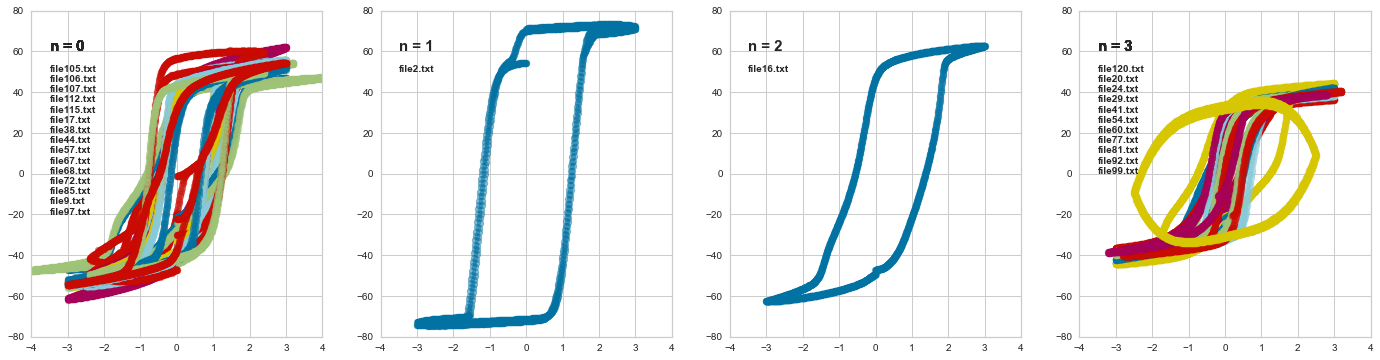

In [80]:
# Plot Hys loops from their respective cluster
fig, ax=plt.subplots(1,visualizer.elbow_value_)
fig.set_size_inches(6*visualizer.elbow_value_,6)
for _ in range (0,visualizer.elbow_value_):
    idx=dfK.query('ClusterID=={}'.format(_)).index
    for x in enumerate(idx):
        ax[_].scatter(dfB.iloc[:,x[1]],dfA.iloc[:,x[1]],alpha=0.5)
        ax[_].set_xlim(-4,4)
        ax[_].set_ylim(-80,80)  
        ax[_].text(-3.5,60,'n = {}'.format(_),fontsize=15,fontweight='bold')
        ax[_].text(-3.5,50-(5*x[0]),'{}'.format(dfK.FName[x[1]]),fontsize=10,fontweight='bold')